# Predicting the past, United States

## Introduction

In the United States, 112 commercial reactors have been deployed and operated since 1967. Predicting the past repository uses published data of those commercial reactors and simulates these reactors using _CYCLUS_, an agent-based simulation software, to predict and compare information such as the amount of power generated. Furthermore, these simulations can be used as baseline comparison models for any future studies that involve simulations modelling or predicting the future such is as DOE-NE's study to screen fuel cycle options that aims to identify the potential benefits and challegnes of fuel cycle options.


## Obtaining Recipes for Simulation

First, a input file for _CYCLUS_ that specifies information such as the simulation start year, reactor deployment year, facility deployment, and recipes for fresh and spent nuclear fuel (SNF) need to be produced. The recipes for fresh and SNF were obtained from `vision_recipes.xls` spreadsheet file. The file contains composition data for fresh and spent nuclear fuel for uranium oxide (UOX) and mixed oxide (MOX) fuels for different burn ups.

Importing raw composition data from `vision_recipes.xls` was performed through python and will be demonstrated below. Due to limited information regarding the reactors, all reactors were assumed to operate at a burn up of 51 GWd/MTHM.

### Demonstration
__Import necessary libraries__

In [1]:
from pyne import nucname as nn
import csv
import jinja2
import os
import sys

__Read fuel recipe data__

Opens and saves contents from `vision_recipes.xls` files to a list by looping over each cell in the spreadsheet file.

In [2]:
def import_csv(in_csv, delimit):
    """ Imports contents of a comma delimited csv file
    to a 2D list.

    Parameters
    ---------
    in_csv: str
        csv file name.
    delimit: str
        delimiter of the csv file

    Returns
    -------
    data_list: list
        list with fleetcomp data.
    """
    with open(in_csv, encoding='utf-8') as source:
        sourcereader = csv.reader(source, delimiter=delimit)
        data_list = []
        for row in sourcereader:
            data_list.append(row)
    return data_list

recipes = import_csv('import_data/vision_recipes/uox.csv', ',')
recipes

[['Fuel Recipe Column # ==>', '1', '2', '3', '4', '5', '6', '7'],
 ['Isotope',
  'UOX 33 Bu fresh',
  'UOX 33 Bu SF',
  'UOX 51 Bu fresh',
  'UOX 51 Bu SF',
  'UOX 100 Bu fresh',
  'UOX 100 Bu SF',
  'Depleted U Composition'],
 ['He4',
  '0',
  '2.09687731425456E-07',
  '0',
  '9.47457840128509E-07',
  '0',
  '2.0692755421168E-06',
  '0'],
 ['Ra226',
  '0',
  '1.18893043712383E-14',
  '0',
  '9.78856442957042E-14',
  '0',
  '0',
  '0'],
 ['Ra228',
  '0',
  '6.05164592554536E-21',
  '0',
  '2.75087759176098E-20',
  '0',
  '6.0138599011451E-20',
  '0'],
 ['Pb206',
  '0',
  '7.66855132237399E-20',
  '0',
  '5.57475193532078E-18',
  '0',
  '1.40345550165974E-17',
  '0'],
 ['Pb207',
  '0',
  '6.51861860354101E-17',
  '0',
  '1.68592497990149E-15',
  '0',
  '4.17687747042409E-15',
  '0'],
 ['Pb208',
  '0',
  '1.2309279798986E-13',
  '0',
  '3.6888358546006E-12',
  '0',
  '9.17047581755368E-12',
  '0'],
 ['Pb210',
  '0',
  '2.49685391210951E-20',
  '0',
  '3.02386544437848E-19',
  '0',
  '7.2

__Load template for _CYCLUS_ input file__

Imports the template file used to render recipe data.

In [3]:
def load_template(in_template):
    """ Returns a jinja2 template.

    Parameters
    ---------
    in_template: str
        template file name.

    Returns
    -------
    output_template: jinja template object
    """
    with open(in_template, 'r') as default:
        output_template = jinja2.Template(default.read())
    return output_template

recipe_template = load_template('templates/US/recipes_template.xml')
recipe_template

<Template memory:7f6b4685d780>

__Select appropriate recipe for a given burnup__

Uses the imported list and a given amount of burnup to select the appropriate composition data. The data is then stored into a dictionary. 

In [4]:
def get_composition(in_list, burnup):
    """ Returns a dictionary of isotope name and composition
    for spent nuclear fuel (SNF) at a given burnup

    Parameters
    ---------
    in_list: list
        list file containing recipe data.
    burnup: int
        path and name of reactors that will be added to cyclus simulation.

    Returns
    -------
    data_dict: dictionary
        dictionary with key: isotope, and value: composition.
    """
    data_dict = {}
    for i in range(len(in_list)):
        if i > 1:
            if burnup == 33:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][2])})
            elif burnup == 51:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][4])})
            else:
                data_dict.update({nn.id(in_list[i][0]):
                                  float(in_list[i][6])})
    return data_dict

composition = get_composition(recipes, 51)
composition

{10030000: 8.58461800264195e-08,
 20040000: 9.47457840128509e-07,
 60140000: 4.05781943561107e-11,
 360810000: 4.21681236076192e-11,
 360850000: 3.44484671160181e-05,
 380900000: 0.0007880649,
 430990000: 0.0011409492,
 531290000: 0.0002731878,
 551340000: 0.0002300898,
 551350000: 0.0006596706,
 551370000: 0.0018169192,
 822060000: 5.57475193532078e-18,
 822070000: 1.68592497990149e-15,
 822080000: 3.6888358546006e-12,
 822100000: 3.02386544437848e-19,
 832090000: 6.60770597104927e-16,
 882260000: 9.78856442957042e-14,
 882280000: 2.75087759176098e-20,
 892270000: 3.0968621961773e-14,
 902280000: 8.47562285269577e-12,
 902290000: 2.72787861516683e-12,
 902300000: 2.6258831537493e-09,
 902320000: 4.17481422959e-10,
 912310000: 9.24658854635179e-10,
 922320000: 1e-09,
 922330000: 2.21390148606282e-09,
 922340000: 0.0001718924,
 922350000: 0.0076486597,
 922360000: 0.0057057461,
 922380000: 0.9208590237,
 932370000: 0.0006091729,
 942380000: 0.000291487,
 942390000: 0.0060657301,
 942400

__Render recipe template with recipe data__

Uses `jinja2` to render recipe data stored in a dictionary to `recipe_template` and `pyne` to convert isotope name for _CYCLUS_. Saves rendered object file to an xml file for use with _CYCLUS_.

In [5]:
def write_recipes(in_dict, in_template, burnup):
    """ Renders jinja template using data from in_list and
    outputs an xml file for a single reactor.

    Parameters
    ---------
    data_dict: dictionary
        dictionary with key: isotope, and value: composition.
    in_template: jinja template object
        jinja template object to be rendered.

    Returns
    -------
    null
        generates reactor files for cyclus.
    """
    rendered = in_template.render(vision=in_dict)
    with open('cyclus/input/US/recipes/uox_' + str(burnup) +
              '.xml', 'w') as output:
        output.write(rendered)

write_recipes(composition, recipe_template, 51)

[uox_51.xml](cyclus/input/US/recipes/uox_51.xml) file shows the rendered result. 

__recipe template__

`jinja2` allows iteration over iterable objects such as lists, sets, and dictionaries. This allows end-users to produce rendered output files that vary in length depending on the data that it has been rendered with. An example is shown below.

Recipe template file:

```
    <recipes>
      <recipe>
        <name>fresh_uox</name>
        <basis>atom</basis>
        <nuclide>
          <id>922350000</id>
          <comp>4.5</comp>
        </nuclide>
        <nuclide>
          <id>922380000</id>
          <comp>95.5</comp>
        </nuclide>
      </recipe>
      <recipe>
        <name>spent_uox</name>
        <basis>atom</basis>
        {% for key, value in vision.items() -%}
        <nuclide>  <id>{{ key }}</id>  <comp>{{ value }}</comp>  </nuclide>
        {% endfor -%}
      </recipe>
    </recipes>
```

The template is a template for an xml file that follows the _CYCLUS_ xml schema. `jinja2` recognizes the for-loop in the following lines 
```
    {% for key, value in vision.items() -%}`
    <nuclide>  <id>{{ key }}</id>  <comp>{{ value }}</comp>  </nuclide>
    {% endfor -%}
```
and iterates over the composition dictionary to render the isotope and its composition.

[uox_51.xml](cyclus/input/US/recipes/uox_51.xml) file shows the rendered result. 

## Obtaining Deployment Data

Reactors specified in [US fleetcomp](import_data/fleetcomp/US_Fleet.txt) spreadsheet, need to be properly imported and deployed at the correct timesteps for a successful simulation. The spreadsheet file contains reactor informations such as name, deployment date, end date, extended end date, and  power generated. These information are useful for an accurate _CYCLUS_ simulation. 

Obtaining information regarding reactors for _CYCLUS_ is also performed using a set of python functions. The same generic steps are repeated for this demonstration: importing data stored in a delimited text file, and rendering the imported data to a template file for _CYCLUS_

### Demonstration
__Read fleetcomp reactor data__

The `import_csv` function is also used for this application and will be used for any other functions that requires data stored in a spreadsheet file to be imported.

In [6]:
fleetcomp = import_csv('import_data/fleetcomp/US_Fleet.txt', '\t')
fleetcomp

[['Haddam Neck',
  '1635.00',
  '587',
  '560',
  'BWR',
  '120',
  '348',
  '10440',
  '96880',
  '12',
  '1',
  '1967',
  '12',
  '4',
  '1996',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '540',
  '83',
  '1998',
  '3',
  '16.4',
  '16.4',
  '50',
  '1900',
  '16.4',
  '16.4',
  '50',
  '1968',
  '17.03',
  '17.03',
  '52',
  '1973',
  '20.5',
  '20.5',
  '54',
  '1978',
  '23.44',
  '23.44',
  '54',
  '1983',
  '23.44',
  '23.44',
  '63',
  '1988',
  '30.3',
  '30.3',
  '70',
  '1993',
  '34.58',
  '34.58',
  '78',
  '1998',
  '38.76',
  '38.76',
  '87',
  '2003',
  '43.02',
  '43.02',
  '91',
  '2008',
  '44.72',
  '44.72',
  '91',
  '2013'],
 ['Oyster Creek',
  '1930.00',
  '641',
  '619',
  'BWR',
  '144',
  '472',
  '14160',
  '92036',
  '12',
  '1',
  '1969',
  '4',
  '9',
  '2009',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '540',
  '83',
  '1998',
  '3',
  '16.4',
  '16.4',
  '50',
  '1900',
  '16.4',
  '16.4',
  '50',
  '1968',
  '17.03',
  '17.03',
  '52',
  '1973',
  '20

__Load template for _CYCLUS input file__

An xml-template that complies with _CYCLUS_ xml schema for _CYCAMORE::REACTORS_ archetype is used for rendering.

In [7]:
reactor_template = load_template('templates/reactors_template.xml')
reactor_template

<Template memory:7f6b467e95f8>

__Select and render useful reactor information__

In this step, the following raw information is obtained from the fleetcomp text file: reactor name, type, number of batches, core mass, lifetime, and capacity. Other information, such as number of assemblies, assemblies per batch, and mass of assembly is derived using reactor type and mass of core. For these derived variables, a typical value for reactors is quoted from the book, _Book Name Here_.


The function loops over each row (reactor) and checks the type of reactor. Then, it obtains all the raw and derived variables necessary and renders the information to the template.

The result of this function is 112 xml files with each xml file containing data for a reactor in the United States.

In [8]:
def write_reactors_xml(in_list, in_template):
    """ Renders jinja template using data from in_list and
    outputs an xml file for a single reactor.

    Parameters
    ---------
    in_list: list
        list file containing fleetcomp data.
    in_template: jinja template object
        jinja template object to be rendered.

    Returns
    -------
    null
        generates reactor files for cyclus.
    """
    for col, item in enumerate(in_list):
        reactor_type = in_list[col][6]
        batch = int(in_list[col][24])
        assem_per_batch = 0
        assem_no = 0
        assem_size = 0
        if reactor_type == 'BWR':
            assem_no = 732
            assem_per_batch = assem_no / batch
            assem_size = float(in_list[col][8]) / assem_no
        else:
            assem_no = 240
            assem_per_batch = int(assem_no / batch)
            assem_size = float(in_list[col][8]) / assem_no
        rendered = in_template.render(name=in_list[col][0].replace(' ', '_'),
                                      lifetime=in_list[col][6],
                                      assem_size=assem_size,
                                      n_assem_core=assem_no,
                                      n_assem_batch=assem_per_batch,
                                      power_cap=in_list[col][2])
        with open('cyclus/input/US/reactors/' +
                  in_list[col][0].replace(' ', '_') +
                  '.xml', 'w') as output:
            output.write(rendered)
            
write_reactors_xml(fleetcomp, reactor_template)

[reactors](cyclus/input/US/reactors) folder contains xml files for all the reactors that will be deployed in the _CYCLUS_ simulation.

## Writing Deployment

Since the reactor information were obtained and saved to files, they need to be properly deployed at the approriate timestep during the simulation. To do so, build time needs to be calculated. This is done by obtaining the difference between the start date of the simulation and the reactor start date. Since _CYCLUS_ default timestep is a month, the differece is also calculated in months.

### Demonstration 
__Read fleetcomp reactor data__

The `import_csv` function is also used for this application and will be used for any other functions that requires data stored in a spreadsheet file to be imported.

In [9]:
fleetcomp = import_csv('import_data/fleetcomp/US_Fleet.txt', '\t')
fleetcomp

[['Haddam Neck',
  '1635.00',
  '587',
  '560',
  'BWR',
  '120',
  '348',
  '10440',
  '96880',
  '12',
  '1',
  '1967',
  '12',
  '4',
  '1996',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '540',
  '83',
  '1998',
  '3',
  '16.4',
  '16.4',
  '50',
  '1900',
  '16.4',
  '16.4',
  '50',
  '1968',
  '17.03',
  '17.03',
  '52',
  '1973',
  '20.5',
  '20.5',
  '54',
  '1978',
  '23.44',
  '23.44',
  '54',
  '1983',
  '23.44',
  '23.44',
  '63',
  '1988',
  '30.3',
  '30.3',
  '70',
  '1993',
  '34.58',
  '34.58',
  '78',
  '1998',
  '38.76',
  '38.76',
  '87',
  '2003',
  '43.02',
  '43.02',
  '91',
  '2008',
  '44.72',
  '44.72',
  '91',
  '2013'],
 ['Oyster Creek',
  '1930.00',
  '641',
  '619',
  'BWR',
  '144',
  '472',
  '14160',
  '92036',
  '12',
  '1',
  '1969',
  '4',
  '9',
  '2009',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '540',
  '83',
  '1998',
  '3',
  '16.4',
  '16.4',
  '50',
  '1900',
  '16.4',
  '16.4',
  '50',
  '1968',
  '17.03',
  '17.03',
  '52',
  '1973',
  '20

__Calculate build times for reactors__

The build time for reactors is obtained by calculating the difference between the reactor start date and the simulation start date in months. This needs to be performed for all reactors that were obtained from the previous step. This was performed using three functions: `deploy_reactors`, `get_build_time` and `write_deployment`. 

The `deploy_reactors` function stores the path of all the reactors files produced in the previous step. It also imports the `fleetcomp` spreadsheet file, which contains reactor information, and passes these two variables into `get_build_time` function which calculates the difference between the simulation start date (01/01/1965), and the reactor start date. The difference in days were converted to months by calculating the average number of days in a month thorughout a year. Then, the results of the calculations are stored in a dictionary with key as reactor name and value as difference in months. Finally, this dictionary and the templates are passed onto `write_deployment` function, which renders the data stored in the dictionary to the `jinja2` template objects.

In [10]:
def deploy_reactors(in_csv, deployinst_template, inclusions_template, path):
    """ Generates xml files that specifies the reactors that will be included
    in a cyclus simulation.
    Parameters
    ---------
    in_csv: str
        csv file name.
    deployinst_template: jinja template object
        jinja template object to be rendered with deployinst.
    inclusions_template: jinja template object
        jinja template object to be rendered with reactor inclusions.
    path: str
        path to reactors folder
    Returns
    -------
    null
        generates single xml file that includes reactors specified in
        the dictionary.
    """
    lists = []
    if path[-1] != '/':
        path += '/'
    for files in os.listdir(path):
        lists.append(path + files)
    fleet_list = import_csv(in_csv, '\t')
    print('fleet_list: \n', fleet_list)
    buildtime_dict = get_build_time(fleet_list, lists)
    print('buildtime_dict: \n', buildtime_dict)
    deployinst_temp = load_template(deployinst_template)
    inclusions_temp = load_template(inclusions_template)
    write_deployment(buildtime_dict, deployinst_temp, inclusions_temp)
    

def get_build_time(in_list, path_list):
    """ Returns a dictionary of reactor name and build_time (in months)
    using the fleetcomp list for reactors specified in *args.
    Parameters
    ---------
    in_list: list
        list file containing fleetcomp data.
    path_list: str
        path and name of reactors that will be added to cyclus simulation.
    Returns
    -------
    data_dict: dictionary
        dictionary with key: reactor name, and value: buildtime.
    """
    data_dict = {}
    for row, item in enumerate(in_list):
        start_date = [in_list[row][11], in_list[row][9], in_list[row][10]]
        month_diff = int((int(start_date[0]) - 1965) * 12 +
                         int(start_date[1]) +
                         int(start_date[2]) / (365.0 / 12))
        for index, reactor in enumerate(path_list):
            fleet_name = in_list[row][0].replace(' ', '_')
            file_name = (reactor.replace(
                os.path.dirname(path_list[index]), '')).replace('/', '')
            if (fleet_name + '.xml' == file_name):
                data_dict.update({fleet_name: month_diff})

    return data_dict


def write_deployment(in_dict, deployinst_template, inclusions_template):
    """ Renders jinja template using dictionary of reactor name and buildtime
    and outputs an xml file that uses xinclude to include the reactors located
    in cyclus_input/reactors.

    Parameters
    ---------
    in_dict: dictionary
        dictionary with key: reactor name, and value: buildtime.
    deployinst_template: jinja template object
        jinja template object to be rendered with deployinst.
    inclusions_template: jinja template object
        jinja template object to be rendered with reactor inclusions.

    Returns
    -------
    null
        generates single xml file that includes reactors specified in
        the dictionary.
    """
    rendered_deployinst = deployinst_template.render(reactors=in_dict)
    rendered_inclusions = inclusions_template.render(reactors=in_dict)
    with open('cyclus/input/US/buildtimes/deployinst.xml', 'w') as output1:
        output1.write(rendered_deployinst)
    with open('cyclus/input/US/buildtimes/inclusions.xml', 'w') as output2:
        output2.write(rendered_inclusions)
        
deploy_reactors('import_data/fleetcomp/US_Fleet.txt',
                'templates/US/deployinst_template.xml',
                'templates/inclusions_template.xml',
                'cyclus/input/US/reactors/')

fleet_list: 
 [['Haddam Neck', '1635.00', '587', '560', 'BWR', '120', '348', '10440', '96880', '12', '1', '1967', '12', '4', '1996', '0', '0', '0', '0', '0', '0', '540', '83', '1998', '3', '16.4', '16.4', '50', '1900', '16.4', '16.4', '50', '1968', '17.03', '17.03', '52', '1973', '20.5', '20.5', '54', '1978', '23.44', '23.44', '54', '1983', '23.44', '23.44', '63', '1988', '30.3', '30.3', '70', '1993', '34.58', '34.58', '78', '1998', '38.76', '38.76', '87', '2003', '43.02', '43.02', '91', '2008', '44.72', '44.72', '91', '2013'], ['Oyster Creek', '1930.00', '641', '619', 'BWR', '144', '472', '14160', '92036', '12', '1', '1969', '4', '9', '2009', '0', '0', '0', '0', '0', '0', '540', '83', '1998', '3', '16.4', '16.4', '50', '1900', '16.4', '16.4', '50', '1968', '17.03', '17.03', '52', '1973', '20.5', '20.5', '54', '1978', '23.44', '23.44', '54', '1983', '23.44', '23.44', '63', '1988', '30.3', '30.3', '70', '1993', '34.58', '34.58', '78', '1998', '38.76', '38.76', '87', '2003', '43.02', '43

[deployinst.xml](cyclus/input/US/buildtimes/deployinst.xml) and [inclusions.xml](cyclus/input/US/buildtimes/inclusions.xml) show the rendered result. 

`deployinst.xml` contains configurations for the _CYCAMORE::DeployInst_ archetype for the reactors in the simulation and `inclusions.xml` contains xml inclusions so that _CYCLUS_ can find and include the reactor files produced during __Obtaining Deployment Data__ step.

## XML inclusion and  Setting XML base for final input file

It is important to make sure that an xml base has been specified when xml inclusions through `XInclude` has been used. `XInclude` is an easy way to include xml files within other xml files. This introduces modularity to _CYCLUS_ input files and simulations. 

__XInclude basics__

In order to use `XInclude` simply add the `XInclude` namespace to the root element of the xml file that needs to include another xml file.

> xmlns:xi="http://www.w3.org/2001/XInclude"

Then, reference the xml file that needs to be added to the base xml file using an `href` tag under the `XInclude` namespace.

> `<xi:include href="link_to_xml_file_to_be_added.xml" />`


__Example__

Below is an example of xml inclusion from the final _CYCLUS_ [input file](cyclus/input/US.xml) (click to open the full file).
```
<simulation xml:base="/home/gyutae/cyclus/predicting-the-past/cyclus/input/"
  xmlns:xi="http://www.w3.org/2001/XInclude">
  <control>
    <duration>1020</duration>
    <startmonth>1</startmonth>
    <startyear>1965</startyear>
  </control>
  <archetypes>
    <spec><lib>cycamore</lib> <name>Enrichment</name> </spec>
    <spec><lib>cycamore</lib> <name>Reactor</name>    </spec>
    <spec><lib>cycamore</lib> <name>Sink</name>       </spec>
    <spec><lib>cycamore</lib> <name>Source</name>     </spec>
    <spec><lib>cycamore</lib> <name>Storage</name>    </spec>
    <spec><lib>cycamore</lib> <name>DeployInst</name> </spec>
    <spec><lib>cycamore</lib> <name>ManagerInst</name></spec>
    <spec><lib>agents</lib>   <name>NullRegion</name> </spec>
  </archetypes>
  <xi:include href="US/buildtimes/inclusions.xml#xpointer(/inclusions/child::*)"/>
.
.
.
```
As shown above, `XInclude` namespace has been added to the root element: `simulation`. The xml file to be added (inclusions.xml) is declared under the namespace using `xi:include` with the relative link `US/buildtimes/inclusions.xml#xpointer(/inclusions/child::*)`.

__Rationale for setting xml base__

One issue that arises with the use of relative path to reference an external entity in XInclude, is that the xml parser does not know the base path of which the xml file referenced using the relative path should be based off. Thus, parsing the xml from different directory yields different results and often produces unable-to-find-external-entity errors. Setting an xml base allows the parser to correctly find the referenced files.

__Setting an xml base__

Setting an xml base is done by finding the absolute path of the _CYCLUS_ input file, and using `jinja2` to render the absolue path using an input file template. 

In [11]:
def set_xml_base(cyclus_template, path, output_name):
    """ Sets xml:base attribute for cyclus input

    Parameters
    ---------
    cyclus_template: str
        path and name to cyclus input template
    path: str
        relative path to cyclus input file
    output_name: str
        name of the output file

    Returns
    -------
    null
        generates single xml file that includes reactors specified in
        the dictionary.
    """
    path = os.path.abspath(path) + '/'
    cyclus_input = load_template(cyclus_template).render(base_dir=path)
    with open(path + output_name + '.xml', 'w') as output1:
        output1.write(cyclus_input)
        
set_xml_base('templates/US/US_template.xml', 'cyclus/input/', 'US')

[US.xml](cyclus/input/US.xml) shows the final _CYCLUS_ input file with all the xml inclusions and xml base.

__Running _CYCLLUS_ Simulation__

Using the final input file above, a _CYCLUS_ simulation was run using the following command on bash:

In [12]:
! rm cyclus/US.sqlite
! cyclus --input-file cyclus/input/US.xml -o cyclus/US.sqlite

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

The first command removes the previous output file if it exists. This is to prevent the final output file from having the results of the previous simulation, which is unwanted for this simulation.

The output file is named [US.sqlite](cyclus/US.sqlite). The results of the simulation are stored as an SQLite file. Thus, a set of functions were written in python to make sqlite queries. With python, the results of the queries can be processed to perform a more meaningful analysis.

## Analysis and Results

The results for the analysis performed above are shown below. Unfortunately, the only data that is available for comparison is the power generated over time. NEI has also published this on their website (US Nuclear Generating Statistics). The data published by the NEI was saved in a spreadsheet so that it can be plotted for comparison. Since the data contains power generated by US nuclear power plants from 1971 to 2016, a new plot was generated to only show the power generated between that period in Figure 10. The plot of power generated produced from the data published by the NEI is shown in Figure 11.

__Import Necessary Libraries__

In [13]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as lite
import sys
from matplotlib import cm
from pyne import nucname
from IPython.display import Image

sys.path.append('analysis/')
import analysis as an

__Connect to SQLite file__

To make sqlite queries in _python_, a cursor, which acts like a pointer to the sqlite file is required. The use of `row_factory` class allows columns in the sqlite table to be indexed by both integer values and by their case-insensitive name. The use of row_factory allows easy debugging, and prevents confusion that may arrise from the change of sqlite queries.

In [14]:
def get_cursor(file_name):
    """ Connects and returns a cursor to an sqlite output file

    Parameters
    ----------
    file_name: str
        name of the sqlite file

    Returns
    -------
    sqlite cursor3
    """
    con = lite.connect(file_name)
    con.row_factory = lite.Row
    return con.cursor()

cursor = get_cursor('cyclus/US.sqlite')

__Get simulation start time, duration, and timestep__

Since all analysis resuls will be plotted for a visual representation, simulation start time, and timestep are obtained by making an sqlite query.

In [15]:
def get_timesteps(cur):
    """ Returns simulation start year, month, duration and
    timesteps (in numpy linspace).

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    init_year: int
        start year of simulation
    init_month: int
        start month of simulation
    duration: int
        duration of simulation
    timestep: list
        linspace up to duration
    """
    info = cur.execute('SELECT initialyear, initialmonth, '
                       'duration FROM info').fetchone()
    init_year = info['initialyear']
    init_month = info['initialmonth']
    duration = info['duration']
    timestep = np.linspace(0, duration - 1, num=duration)

    return init_year, init_month, duration, timestep


ini_yr, ini_month, dur, timestep = get_timesteps(cursor)
print(ini_yr, ini_month, dur, timestep)

1965 1 1020 [  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   1.01700000e+03
   1.01800000e+03   1.01900000e+03]


__Nat_u consumption vs Time__

`nat_u_timeseries` function returns a timeseries list of natural uranium sent into the enrichment facility. Unfortunately, this does not represent the real amount of natural uranium used as _CYCAMORE::enrichment_ facilty does not enrich fuel on a need-basis. If _CYCAMORE::enrichment_ gets updated to enrich fuel on a need-basis, this analysis would be more accurate.

The `nat_u_timeseries` function makes an sqlite query on the `timeseriesenrichmentfeed` table and passes on the results to `get_timeseries_cum` function. The `get_timeseries_cum` function calculates the chronological cumulative sum of the amount of transactions that has happened over a period of time. The resulting timeseries list is often used to plot the change in certain commodities over time.

In [16]:
def nat_u_timeseries(cur):
    """ Finds natural uranium supply from source
        Since currently the source supplies all its capacity,
        the timeseriesenrichmentfeed is used.

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    get_timeseries: function
        calls a function that returns timeseries list of natural U
        demand from enrichment [MTHM]
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    # Get Nat U feed to enrichment from timeseriesenrichmentfeed
    feed = cur.execute('SELECT time, sum(value) '
                       'FROM timeseriesenrichmentfeed '
                       'GROUP BY time').fetchall()

    return get_timeseries_cum(feed, duration, True)


def get_timeseries_cum(in_list, duration, kg_to_tons):
    """ returns a timeseries list from in_list data.

    Parameters
    ----------
    in_list: list
        list of data to be created into timeseries
        list[0] = time
        list[1] = value, quantity
    multiplyby: int
        integer to multiply the value in the list by for
        unit conversion from kilograms
    kg_to_tons: bool
        if True, list returned has units of tons
        if False, list returned as units of kilograms

    Returns
    -------
    timeseries of commodities in kg or tons
    """
    value = 0
    value_timeseries = []
    array = np.array(in_list)
    if len(in_list) > 0:
        for i in range(0, duration):
            value += sum(array[array[:, 0] == i][:, 1])
            if kg_to_tons:
                value_timeseries.append(value * 0.001)
            else:
                value_timeseries.append(value)
    return value_timeseries


consumption = {'Nat_u_consumption': nat_u_timeseries(cursor)}
print(consumption)

{'Nat_u_consumption': [0.0, 0.0, 0.0, 0.0, 0.0, 999.99999999999977, 1999.9999999999995, 2999.9999999999991, 3999.9999999999991, 4999.9999999999991, 5999.9999999999991, 6999.9999999999991, 7999.9999999999991, 8999.9999999999982, 9999.9999999999982, 10999.999999999998, 11999.999999999998, 12999.999999999998, 13999.999999999998, 14999.999999999998, 15999.999999999998, 16999.999999999996, 17999.999999999996, 18999.999999999996, 19999.999999999996, 20999.999999999996, 21999.999999999996, 22999.999999999996, 23999.999999999996, 24999.999999999996, 25999.999999999996, 26999.999999999996, 27999.999999999996, 28999.999999999996, 29999.999999999996, 30999.999999999996, 31999.999999999996, 33000.0, 33999.999999999993, 34999.999999999993, 35999.999999999993, 36999.999999999993, 37999.999999999993, 38999.999999999993, 39999.999999999993, 40999.999999999993, 41999.999999999993, 42999.999999999993, 43999.999999999993, 44999.999999999993, 45999.999999999993, 46999.999999999993, 47999.999999999993, 489

The resulting timeseries list is passed onto `stacked_bar_chart` function for plotting.

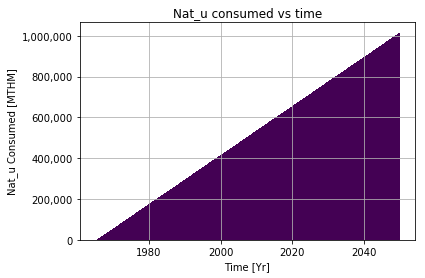

In [17]:
an.stacked_bar_chart(consumption, timestep,
                     'Time [Yr]', 'Nat_u Consumed [MTHM]',
                     'Nat_u consumed vs time',
                     'analysis/results/US/Nat_u consumption',
                     ini_yr)

Image(filename = 'analysis/results/US/Nat_u consumption.png')

As shown in the figure above, the mass of natural uranium consumed over the period of the simulation linearly increases. This indicates that the enrichment facility enriches fuel at a contant rate throughout the simulation, regardless of the demand for fresh fuel. This will hopefully be improved in the future so that the enrichment facilities also take the demand for fresh fuel into account.

__Amount of fuel into reactors vs. time__

A more accurate analysis for fuel consumption would be the amount of fuel sent to reactors over time. While the enrichment facility constantly produces fresh fuel, the total amount of fuel sent to reactors change based on the number and size of the reactors in operation at each timestep. This is performed with the `fuel_into_reactors` function, which makes an sqlite query to the `resources`, `transactions`, and `agententry` table to obtain the amount of each fuel sent to reactors throughout the simulation. The resulting data is sent to `get_timeseries_cum` function to obtain the timeseries list of different fuels sent to reactors throughout the simulation.

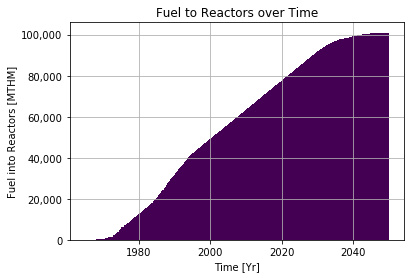

In [18]:
def fuel_into_reactors(cur):
    """ Finds timeseries of mass of fuel received by reactors

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    timeseries list of fuel into reactors [tons]
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                       'INNER JOIN resources ON '
                       'resources.resourceid = transactions.resourceid '
                       'INNER JOIN agententry ON '
                       'transactions.receiverid = agententry.agentid '
                       'WHERE spec LIKE "%Reactor%" '
                       'GROUP BY time').fetchall()

    return get_timeseries_cum(fuel, duration, True)


to_reactor = {'Fuel_to_reactor': fuel_into_reactors(cursor)}
an.stacked_bar_chart(to_reactor, timestep,
                     'Time [Yr]', 'Fuel into Reactors [MTHM]',
                     'Fuel to Reactors over Time',
                     'analysis/results/US/Fuel to Reactors over Time', 
                     ini_yr)

Image(filename = 'analysis/results/US/Fuel to Reactors over Time.png')

As shown in the figure above, the amount of fuel into reactors over time is not linear and changes with fuel demand by the reactors. This figure reflects the state of the reactor (whether it is operating or refueling), and the number of reactors. From the plot, it can be seen that the number of reactors greatly increased between 1980 and 2000.

__Fuel utilization vs. time__

Fuel utilization factor is the ratio of fuel spent to the amount of natual uranium consumed. While, fuel utilization factor is a value of interest, it is unfortunately, inaccurate at this moment because the enrichment facilities in _CYCLUS_ does not perform demand-driven fuel enrichment. Since the amount of natural uranium consumed is not accurate due to limitations with software, fuel utilzation factor, which is a derived variable, will still be inaccurate. However, the functions used to calculate the fuel utilization factor over time will still be displayed for future usage. This is performed with `u_util_calc` function, which runs `nat_u_timeseries` function and `fuel_into_reactors` function to obtain the timeseries lists of natural uranium consumed and the amount of fuel consumed. Then, and element-wise division of the two lists were performed to obtain the fuel utilization factor.

/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


The Average Fuel Utilization Factor is: 
0.0966753396887


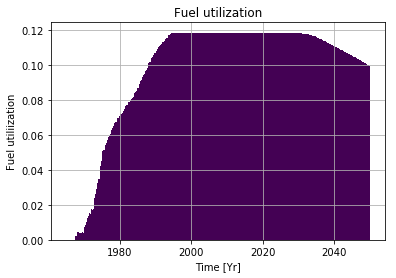

In [19]:
def u_util_calc(cur):
    """ Returns fuel utilization factor of fuel cycle

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    u_util_timeseries: numpy array
        Timeseries of Uranium utilization factor
    Prints simulation average Uranium Utilization
    """
    # timeseries of natural uranium
    u_supply_timeseries = np.array(nat_u_timeseries(cur))

    # timeseries of fuel into reactors
    fuel_timeseries = np.array(fuel_into_reactors(cur))

    # timeseries of Uranium utilization
    u_util_timeseries = np.nan_to_num(fuel_timeseries / u_supply_timeseries)
    print('The Average Fuel Utilization Factor is: ')
    print(sum(u_util_timeseries) / len(u_util_timeseries))

    return u_util_timeseries


fuel_util = {'Fuel Utilization Factor': u_util_calc(cursor)}
an.stacked_bar_chart(fuel_util, timestep,
                     'Time [Yr]', 'Fuel utiliization',
                     'Fuel utilization',
                     'analysis/results/US/Fuel utilization', ini_yr)

Image(filename = 'analysis/results/US/Fuel utilization.png')

__Capacity vs. time__

Total capacity over time is obtained using `get_power_dict` function and `capacity_calc` function. The `get_power_dict` function performs four sqlite queries to obtain the following: simulation start date, timesteps, institutions declared in _CYCLUS_, and reactors entry and exit timesteps. The results are sent to `capacity_calc` function, which calculates the timeseries value of the total capacity of the reactors in each institution.

FuelCycle has no values


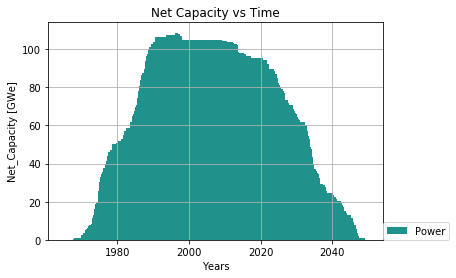

In [20]:
def get_power_dict(cur):
    """ Gets dictionary of power capacity by calling capacity_calc

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    ------
    power_dict: dictionary
        "dictionary with key=government, and
        value=timeseries list of installed capacity"
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    governments = get_inst(cur)

    # get power cap values
    entry = cur.execute('SELECT max(value), timeseriespower.agentid, '
                        'parentid, entertime FROM agententry '
                        'INNER JOIN timeseriespower '
                        'ON agententry.agentid = timeseriespower.agentid '
                        'GROUP BY timeseriespower.agentid').fetchall()

    exit_step = cur.execute('SELECT max(value), timeseriespower.agentid, '
                            'parentid, exittime FROM agentexit '
                            'INNER JOIN timeseriespower '
                            'ON agentexit.agentid = timeseriespower.agentid'
                            ' INNER JOIN agententry '
                            'ON agentexit.agentid = agententry.agentid '
                            'GROUP BY timeseriespower.agentid').fetchall()

    return capacity_calc(governments, timestep, entry, exit_step)


def get_inst(cur):
    """ Returns prototype and agentids of institutions

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    sqlite query result (list of tuples)
    """
    return cur.execute('SELECT prototype, agentid FROM agententry '
                       'WHERE kind = "Inst"').fetchall()


def capacity_calc(governments, timestep, entry, exit_step):
    """Adds and subtracts capacity over time for plotting

    Parameters
    ----------
    governments: list
        list of governments (countries)
    timestep: np.linspace
        list of timestep from 0 to simulation time
    entry: list
        power_cap, agentid, parentid, entertime
        of all entered reactors
    exit_step: list
        power_cap, agentid, parenitd, exittime
        of all decommissioned reactors

    Returns
    -------
    power_dict: dictionary
        "dictionary with key=government, and
        value=timeseries list capacity"
    """
    power_dict = collections.OrderedDict()
    for gov in governments:
        capacity = []
        cap = 0
        for t in timestep:
            for enter in entry:
                if (enter['entertime'] == t and
                        enter['parentid'] == gov['agentid']):
                    cap += enter['max(value)'] * 0.001
            for dec in exit_step:
                if (dec['exittime'] == t and
                        dec['parentid'] == gov['agentid']):
                    cap -= dec['max(value)'] * 0.001
            capacity.append(cap)
        power_dict[gov['prototype']] = np.asarray(capacity)

    return power_dict


capacity_dict = get_power_dict(cursor)

an.stacked_bar_chart(capacity_dict, timestep,
                     'Years', 'Net_Capacity [GWe]',
                     'Net Capacity vs Time',
                     'analysis/results/US/Capacity vs Time', 
                     ini_yr)
  
Image(filename = 'analysis/results/US/Capacity vs Time.png')

As shown in the figure above, the net capacity greatly increases between 1965 and 1990. The increase in capacity reflects the increase in the number of reactors in operation. Then, the capacity decreases gradually from around 1995. This trend is also shown in the figure of number of reactors over time below.

__Number of reactors vs time__

A very similar procedure is used to obtain the number of reactors over time. The same four queries made to calculate capacity over time were made to get the number of reactors over time. Then, this is passed to `reactor_deployments` functions, which uses a counter to keep track of the number of reactors operating over time. 

FuelCycle has no values


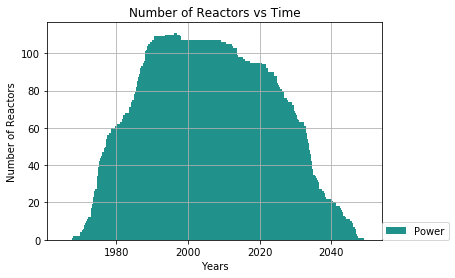

In [21]:
def get_deployment_dict(cur):
    """ Gets dictionary of reactors deployed over time
    by calling reactor_deployments

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    ------
    num_dict: dictionary
        "dictionary with key=government, and
        value=timeseries list of number of reactors"
    """
    init_year, init_month, duration, timestep = get_timesteps(cur)
    governments = get_inst(cur)

    # get power cap values
    entry = cur.execute('SELECT max(value), timeseriespower.agentid, '
                        'parentid, entertime FROM agententry '
                        'INNER JOIN timeseriespower '
                        'ON agententry.agentid = timeseriespower.agentid '
                        'GROUP BY timeseriespower.agentid').fetchall()

    exit_step = cur.execute('SELECT max(value), timeseriespower.agentid, '
                            'parentid, exittime FROM agentexit '
                            'INNER JOIN timeseriespower '
                            'ON agentexit.agentid = timeseriespower.agentid'
                            ' INNER JOIN agententry '
                            'ON agentexit.agentid = agententry.agentid '
                            'GROUP BY timeseriespower.agentid').fetchall()
    
    return reactor_deployments(governments, timestep, entry, exit_step)


def reactor_deployments(governments, timestep, entry, exit_step):
    """Adds and subtracts number of reactors deployed over time
    for plotting

    Parameters
    ----------
    governments: list
        list of governments (countries)
    timestep: np.linspace
        list of timestep from 0 to simulation time
    entry: list
        power_cap, agentid, parentid, entertime
        of all entered reactors

    exit_step: list
        power_cap, agentid, parenitd, exittime
        of all decommissioned reactors

    Returns
    -------
    deployment: dictionary
        "dictionary with key=government, and
        value=timeseries number of reactors"
    """
    deployment = collections.OrderedDict()
    for gov in governments:
        num_reactors = []
        count = 0
        for t in timestep:
            for enter in entry:
                if (enter['entertime'] == t and
                        enter['parentid'] == gov['agentid']):
                    count += 1
            for dec in exit_step:
                if (dec['exittime'] == t and
                        dec['parentid'] == gov['agentid']):
                    count -= 1
            num_reactors.append(count)
        deployment[gov['prototype']] = np.asarray(num_reactors)

    return deployment


an.stacked_bar_chart(get_deployment_dict(cursor), 
                     timestep, 'Years', 
                     'Number of Reactors',
                     'Number of Reactors vs Time',
                     'analysis/results/US/Number of Reactors vs Time', 
                     ini_yr)

Image(filename = 'analysis/results/US/Number of Reactors vs Time.png')

__Power generated vs. time__

The amount of power generated over time is can be calculated from capacity over time with a few assumptions. Power generated can be calculated from capacity with the using the following function.

$$P(t)=C(t)\times CF(t)\times HRPYR$$

where,

$$P(t) = Power\ generated\ over\ a\ year\ [GWh]$$
$$C(t) = Capacity\ over\ time\ [GWe]$$
$$CF(t)= Capacity\ factor$$
$$HRPYR= Number\ of\ hours\ in\ a\ year$$

The following assumptions were used for the calculation above.

1. Refueling time of all reactors is 1 month.
2. Capacity factor is constant throughout the year, and equal for all reactors.
3. Reactor generates its full power even during startup and shutdown.
4. Capacity factor data is obtained from the Energy Information Administration (EIA), which has the average capacity factor for reactors in the United States over a year from 1971 to 2017. The capacity factor is assumed constant from 2016 to the end of the simulation and from 1965 to 1971.

Capacity factor for each year is stored in a separate [spreadsheet file](analysis/published_data/US/capacity_factor_extrapolated.csv). A set of python functions were used to calculate the power generated over time.

In [22]:
hours_in_year = 24 * 365.25
cf_data = import_csv('analysis/published_data/US/capacity_factor_extrapolated.csv', 
                     ',')
cf_data

[['Year', 'Capacity Factor'],
 ['1965', '48.2'],
 ['1966', '48.2'],
 ['1967', '48.2'],
 ['1968', '48.2'],
 ['1969', '48.2'],
 ['1970', '48.2'],
 ['1971', '48.2'],
 ['1972', '42.5'],
 ['1973', '53.5'],
 ['1974', '47.8'],
 ['1975', '55.9'],
 ['1976', '54.7'],
 ['1977', '63.3'],
 ['1978', '64.5'],
 ['1979', '58.4'],
 ['1980', '56.3'],
 ['1981', '58.2'],
 ['1982', '56.6'],
 ['1983', '54.4'],
 ['1984', '56.3'],
 ['1985', '58'],
 ['1986', '56.9'],
 ['1987', '57.4'],
 ['1988', '63.5'],
 ['1989', '62.2'],
 ['1990', '66'],
 ['1991', '70.2'],
 ['1992', '70.9'],
 ['1993', '70.5'],
 ['1994', '73.8'],
 ['1995', '77.4'],
 ['1996', '76.2'],
 ['1997', '71.1'],
 ['1998', '78.2'],
 ['1999', '85.3'],
 ['2000', '88.1'],
 ['2001', '89.4'],
 ['2002', '90.3'],
 ['2003', '87.9'],
 ['2004', '90.1'],
 ['2005', '89.3'],
 ['2006', '89.6'],
 ['2007', '91.8'],
 ['2008', '91.1'],
 ['2009', '90.3'],
 ['2010', '90.9'],
 ['2011', '88.9'],
 ['2012', '86.4'],
 ['2013', '89.9'],
 ['2014', '91.7'],
 ['2015', '92.2'],
 ['20

Assumption 4 can be seen from `cf_data`. The capacity factor is assumed to be constant at 48.2% from 1965 to 1971, and at 92.5% from 2017 to 2049. Power generated at each timestep is calculated by performing an element-wise multiplication of  the capacity factor data and the capacty. However, since capacity factor is stored for each year, Assumption 2 is used. A separate function is used to create a list that stores the capacity factor for each timestep of the simulation.

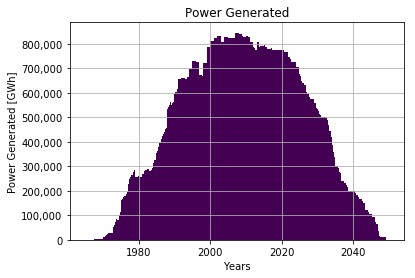

In [23]:
def get_cf(in_list):
    """ Creates a list of capacity factor from
    the imported csv file

    Parameters
    ----------
    in_list: list
        list containing data stored in a csv file

    Returns
    -------
    cf: list
        list of capacity factors per month
    """
    cf = []
    for row in in_list[1:]:
        for i in range(0, 12):
            cf.append(float(row[1]) / 100)

    return cf


cf = np.asarray(get_cf(cf_data))
capacity = capacity_dict['Power']
generated= {"US" : np.multiply(capacity, cf) * hours_in_year}
an.stacked_bar_chart(generated, timestep,
                     'Years', 'Power Generated [GWh]',
                     'Power Generated',
                     'analysis/results/US/Power Generated',
                     ini_yr)

Image(filename = 'analysis/results/US/Power Generated.png')

__Power generated between 1971 and 2016__

The United States Nuclear Energy Institute (NEI) has published the amount of power generated by nuclear power plants in the United States between 1971 and 2016 (US Nuclear Generating Statistics, NEI). This information is used to compare the simulation results with the actual data. Thus, the data obtained from the previous analysis is used to obtain the power generated between 1971 and 2016 by calculating the starting index and the ending index. The actual data is plotted for comparison.

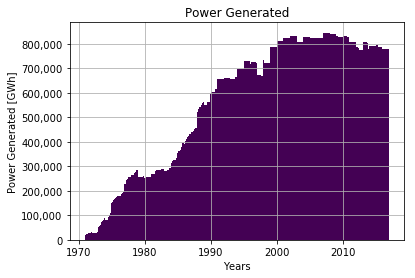

In [24]:
start_year = 1971
end_year = 2017
start_index = (start_year - 1965) * 12
end_index = (end_year - 1965) * 12
dura = end_year - start_year

timestep_range = timestep[start_index: end_index]
cf_range = cf[start_index : end_index]
generated_range  = {"US" : generated["US"][start_index : end_index]}

an.stacked_bar_chart(generated_range, timestep_range,
                     "Years", "Power Generated [GWh]",
                     "Power Generated",
                     "analysis/results/US/Power Generated 1971~2016",
                     1965)

Image(filename = 'analysis/results/US/Power Generated 1971~2016.png')

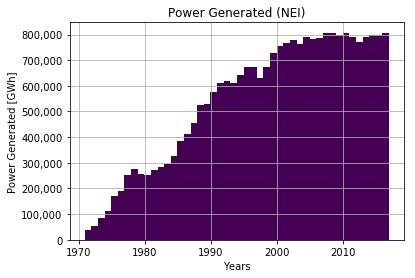

In [25]:
Image(filename = 'analysis/published_data/US/Power Generated NEI.png')

As shown in the two plots above,the plot of power generated between 1971 and 2016 from the _CYCLUS_ simulation matches very closely to that published by the NEI. There are a few differences that can be noticed between the two plots. First, the power generated according to _CYCLUS_ is slightly higher than the power generated according to the NEI. This can be explained from the difference in refueling times between simulation and real-world scenarios. Due to software limitations of _CYCLUS_, refueling time for reactors can only be entered in integers of month, and stays constant throughout the lifetime of the plant whereas actual refueling time can vary in floating points of month and changes depending on various factors.

_CYCLUS_ simulation used to obtain the power generated over time assumes a refueling period of 1 month. According to the NEI, the average  refueling period for reactors in the United States varies quite significantly. The average refueling period in 1990 was 104 days, a period of over 3 months, and generally decreases to an average refueling period of 35 days, a period of just over 1 month, in 2017. As published by the NEI, the average refueling period of nuclear reactors in the United States has been greater than 1 month between 1990 and 2017. This means that the power generated by the reactors deployed in the _CYCLUS_ simulation would have a greater amount of power generated over a period of time.

## Conclusion

To conclude, _CYCLUS_ has been able to perform simulations at a fairly accurate level as shown in the comparison of the power generation plots. Still, some improvements in _CYCLUS_ would be benefitial: the implementation of an enrichment facility that processes fuel on a need basis. There are other improvements that can be potentially made for this simulation to improve its accuracy.

+  Specify actual burnup for reactors
    + Currently, the reactors deployed in Cyclus are all deployed with a burnup of 51 GWd/MTHM. 
    
    
+  Specify reactor n_assembly_core and batch
    + Reactors were deployed in cyclus without the actual number of assemblies per core and batch. The typical values were used for each reactor type (Source needs to be added for the typical values). While the effects of changing these values may not be significant in the outcome of the simulation, specifying such information may benefit the accuracy of the simulation results.
    
    
+  Apply a similar analysis to different regions such as the EU or in the world


## References
*  US Nuclear Generating Statistics. (n.d.). Retrieved from https://www.nei.org/Knowledge-Center/Nuclear-Statistics/US-Nuclear-Power-Plants/US-Nuclear-Generating-Statistics


*  US Nuclear Refueling Outage Days. (n.d.). Retrieved from https://www.nei.org/Knowledge-Center/Nuclear-Statistics/US-Nuclear-Power-Plants/US-Nuclear-Refueling-Outage-Days
